In [44]:
import lightning as L
import torch
from torch import nn
torch.set_float32_matmul_precision('medium')

# Data Prep

In [45]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [46]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [47]:
L.seed_everything(123)

Seed set to 123


123

In [48]:
#Prepare dataset for training
image_path = '../data/CombinedAll'
dest_dir = '../data/CombinedAll'
categories = ['parkinson', 'sehat']

# Create destination directories
for category in categories:
    os.makedirs(os.path.join(dest_dir, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'test', category), exist_ok=True)

# Split and copy files
for category in categories:
    category_path = os.path.join(image_path, category)
    files = os.listdir(category_path)
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    
    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(dest_dir, 'train', category, file))
    
    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(dest_dir, 'test', category, file))

print("Dataset split into training and test sets successfully.")

Dataset split into training and test sets successfully.


In [49]:
from pathlib import Path

In [50]:
# Setup path to data folder
data_path = Path("../data/")
image_path = data_path / "CombinedAll"

In [51]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('../data/CombinedAll/train'),
 WindowsPath('../data/CombinedAll/test'))

# Data Management

In [52]:
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import os

In [53]:
L.seed_everything(123)

Seed set to 123


123

In [54]:
# class DataModule(L.LightningDataModule):
#     def __init__(
#         self,
#         data_dir: str,
#         batch_size: int = 32,
#         num_workers: int = 8,
#         image_size: int = 224
#     ):
#         super().__init__()
#         self.data_dir = data_dir
#         self.batch_size = batch_size
#         self.num_workers = num_workers
#         self.image_size = image_size
#         self.transform = transforms.Compose([
#             transforms.Resize((self.image_size, self.image_size)),
#             transforms.ToTensor()
#         ])

#         self.train_transform = transforms.Compose([
#             transforms.Resize((image_size, image_size)),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomRotation(10),
#             transforms.ToTensor(),
#             transforms.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]
#             )
#         ])
        
#         self.val_transforms = transforms.Compose([
#             transforms.Resize((image_size, image_size)),
#             transforms.ToTensor(),
#             transforms.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]
#             )
#         ])
        
#     def setup(self, stage=None):
#         if stage == 'fit' or stage is None:
#             self.train_dataset = datasets.ImageFolder(
#                 root=os.path.join(self.data_dir, 'train'),
#                 transform=self.train_transforms
#             )
#             self.val_dataset = datasets.ImageFolder(
#                 root=os.path.join(self.data_dir, 'test'),
#                 transform=self.val_transforms
#             )
    
#     def train_dataloader(self):
#         return DataLoader(
#             self.train_dataset,
#             batch_size=self.batch_size,
#             shuffle=True,
#             num_workers=self.num_workers,
#             pin_memory=True
#             persistent_workers=True
#         )

#     def val_dataloader(self):
#         return DataLoader(
#             self.val_dataset,
#             batch_size=self.batch_size,
#             shuffle=False,
#             num_workers=self.num_workers,
#             pin_memory=True
#             persistent_workers=True
#         )

#     def test_dataloader(self):
#         return self.val_dataloader()

In [55]:
num_workers = os.cpu_count() - 8
num_workers
batch_size = 32

In [56]:
vitb16_0_weights = models.ViT_B_16_Weights.DEFAULT 
vitb16_0_transforms = vitb16_0_weights.transforms()
print(vitb16_0_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [57]:
train_transform = transforms.Compose(
   [
      transforms.Resize(256),
      transforms.CenterCrop(224),
      # transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
      # transforms.RandomHorizontalFlip(p=0.5),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   ],
)

test_transform = transforms.Compose(
   [
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   ],
)


In [58]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
train_dataset,val_dataset 

(Dataset ImageFolder
     Number of datapoints: 1011
     Root location: ..\data\CombinedAll\train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 253
     Root location: ..\data\CombinedAll\test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [59]:
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [60]:
# L.seed_everything(123)
# NUM_IMAGES = 4
# images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
# orig_images = [Image.open(train_dataset.samples[idx][0]) for idx in range(NUM_IMAGES)]
# orig_images = [test_transform(img) for img in orig_images]

# img_grid = torchvision.utils.make_grid(torch.stack(images, dim=0), nrow=4, normalize=True, pad_value=0.5)
# img_grid = img_grid.permute(1, 2, 0)

# plt.figure(figsize=(8, 8))
# plt.title("Augmentation examples")
# plt.imshow(img_grid)
# plt.axis("off")
# plt.show()
# plt.close()

In [61]:
from torchvision.transforms import functional as F
import random
import numpy as np

In [62]:

# folder_path = "../data/CombinedAll/sehat"


# image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
# selected_images = random.sample(image_files, 4)


# transform_list = [
#     ("Horizontal Flip", transforms.RandomHorizontalFlip(p=1.0)),
#     ("Rotate 45°", transforms.RandomRotation(degrees=(45, 45))),
#     ("Vertical Flip", transforms.RandomVerticalFlip(p=1.0)),
#     ("Color Jitter", transforms.ColorJitter(brightness=0.5))
# ]


# original_images = []
# transformed_images = []
# titles = []

# for idx, img_file in enumerate(selected_images):
#     img_path = os.path.join(folder_path, img_file)
#     img = Image.open(img_path).convert('RGB')
    
#     original_images.append(img)
    
#     transform = transform_list[idx][1]
#     transformed_img = transform(img)
    
#     transformed_images.append(transformed_img)
#     titles.append(transform_list[idx][0])

# fig, axes = plt.subplots(2, 4, figsize=(30, 20))

# for idx, img in enumerate(original_images):
#     axes[idx//2, idx%2*2].imshow(img)
#     axes[idx//2, idx%2*2].set_title('Original',fontsize=30, color='red')
#     axes[idx//2, idx%2*2].axis('off')

# for idx, (img, title) in enumerate(zip(transformed_images, titles)):
#     axes[idx//2, idx%2*2 + 1].imshow(img)
#     axes[idx//2, idx%2*2 + 1].set_title(f'Transformed: {title}', fontsize=30, color='green')
#     axes[idx//2, idx%2*2 + 1].axis('off')

# plt.tight_layout()
# plt.show()

In [63]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, persistent_workers=True)

# ViT Model Prep

In [64]:
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchmetrics.classification import BinaryConfusionMatrix
import io
import numpy as np

In [65]:
L.seed_everything(123)

Seed set to 123


123

In [66]:
class VisionTransformerClassifier(L.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
        
        for param in self.vit.parameters():
            param.requires_grad = False

        self.vit.heads = nn.Linear(in_features=768, out_features=1)
        
        self.learning_rate = learning_rate
        self.loss_fn = nn.BCEWithLogitsLoss()
        
        self.confusion_matrix = BinaryConfusionMatrix()
    
        self.val_preds = []
        self.val_labels = []
        self.training_step_outputs = []
        self.training_epoch_losses = []
        self.training_epoch_accs = []
        self.validation_epoch_losses = []
        self.validation_epoch_accs = []
        
    def forward(self, x):
        return self.vit(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        loss = self.loss_fn(logits.squeeze(), y)
        preds = torch.sigmoid(logits.squeeze()) > 0.5
        acc = (preds == y).float().mean()        
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        
        self.training_step_outputs.append({'loss': loss, 'acc': acc})
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        preds = torch.sigmoid(logits.squeeze()) > 0.5
        acc = (preds == y).float().mean()
        loss = self.loss_fn(logits.squeeze(), y)
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "val_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        
        self.val_preds.append(preds)
        self.val_labels.append(y)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)
        preds = torch.sigmoid(logits.squeeze()) > 0.5
        acc = (preds == y).float().mean()        
        loss = self.loss_fn(logits.squeeze(), y)
        self.log('test_loss', loss)
        self.log("test_acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=1e-6
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },            
        }

    def on_train_epoch_end(self):
        avg_loss = self.trainer.callback_metrics['train_loss']
        avg_acc = self.trainer.callback_metrics['train_acc']
        
        self.training_epoch_losses.append(avg_loss.item())
        self.training_epoch_accs.append(avg_acc.item())
            
        
        if len(self.training_epoch_losses) > 0:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            
            # Loss plot
            # Omit the first value from the list as its messes up the scale
            ax1.plot(self.training_epoch_losses[1:], label='Train Loss')
            if self.validation_epoch_losses:
                ax1.plot(self.validation_epoch_losses[1:], label='Val Loss')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.legend()
            
            # Accuracy plot
            ax2.plot(self.training_epoch_accs[1:], label='Train Accuracy')
            if self.validation_epoch_accs:
                ax2.plot(self.validation_epoch_accs[1:], label='Val Accuracy')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy')
            ax2.legend()
            
            # Log to tensorboard
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            im = transforms.ToTensor()(Image.open(buf))
            self.logger.experiment.add_image('training_curves', im, global_step=self.current_epoch)
            
            plt.close()
        
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_preds)
        all_labels = torch.cat(self.val_labels)
        self.confusion_matrix(all_preds, all_labels)

        fig, ax = plt.subplots(figsize=(8, 8))
        self.confusion_matrix.plot(ax=ax, labels=["Healthy", "Patient"])
        
        buf = io.BytesIO()
        fig.savefig(buf, format="png")
        buf.seek(0)
        im = transforms.ToTensor()(Image.open(buf))
        
        self.logger.experiment.add_image(
            "confusion_matrix",
            im,
            global_step=self.current_epoch
        )
        
        self.val_preds.clear()
        self.val_labels.clear()
        plt.close()

        self.validation_epoch_losses.append(self.trainer.callback_metrics['val_loss'].item())
        self.validation_epoch_accs.append(self.trainer.callback_metrics['val_acc'].item())

In [67]:
model = VisionTransformerClassifier(learning_rate=1e-3)

In [68]:
from torchinfo import summary

In [69]:
summary(model=model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
VisionTransformerClassifier (VisionTransformerClassifier)         [32, 3, 224, 224]    [32, 1]              --                   Partial
├─VisionTransformer (vit)                                         [32, 3, 224, 224]    [32, 1]              768                  Partial
│    └─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
│    └─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    │    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    │    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       (85,054,464)         False
│    │    └─LayerNorm (ln)                        

In [70]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers.tensorboard import TensorBoardLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [71]:
checkpoint_callback = ModelCheckpoint(
    dirpath="../models/checkpoints",
    monitor="val_loss",
    filename="vitb16-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}",
    save_top_k=3,
    mode="min",
)

logger = TensorBoardLogger(save_dir="../lightning_logs", name="vitb16", )

early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=False)

In [72]:
trainer = L.Trainer(
   max_epochs=20,
   callbacks=[checkpoint_callback, early_stopping],
   logger=logger,
   accelerator="gpu" if torch.cuda.is_available() else "cpu",
   devices="auto",
   log_every_n_steps=1,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [73]:
trainer.fit(model, train_loader, val_loader)

trainer.test(model, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                  | Params | Mode 
-------------------------------------------------------------------
0 | vit              | VisionTransformer     | 85.8 M | train
1 | loss_fn          | BCEWithLogitsLoss     | 0      | train
2 | confusion_matrix | BinaryConfusionMatrix | 0      | train
-------------------------------------------------------------------
769       Trainable params
85.8 M    Non-trainable params
85.8 M    Total params
343.198   Total estimated model params size (MB)
153       Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s, v_num=0, train_loss_step=0.335, train_acc_step=0.895, val_loss_step=0.513, val_acc_step=0.759, val_loss_epoch=0.288, val_acc_epoch=0.885, train_loss_epoch=0.280, train_acc_epoch=0.890]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s, v_num=0, train_loss_step=0.335, train_acc_step=0.895, val_loss_step=0.513, val_acc_step=0.759, val_loss_epoch=0.288, val_acc_epoch=0.885, train_loss_epoch=0.280, train_acc_epoch=0.890]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 8/8 [00:01<00:00,  5.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8853754997253418
        test_loss           0.28794658184051514
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.28794658184051514, 'test_acc': 0.8853754997253418}]

In [74]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd

In [75]:
# ea = event_accumulator.EventAccumulator('../lightning_logs/vitb16/version_0') # Use your latest version
# ea.Reload()
# print("Available tags:", ea.Tags())

In [76]:
# train_loss = pd.DataFrame(ea.Scalars('train_loss_epoch'))
# val_loss = pd.DataFrame(ea.Scalars('val_loss_epoch'))
# train_acc = pd.DataFrame(ea.Scalars('train_acc_epoch'))
# val_acc = pd.DataFrame(ea.Scalars('val_acc_epoch'))
# epochs = pd.DataFrame(ea.Scalars('epoch'))
# train_loss

In [77]:
# epochs

In [78]:
# total_train_samples = len(train_dataset)
# batches_per_epoch = total_train_samples / batch_size
# total_train_samples, batches_per_epoch

In [79]:
# train_epochs = train_loss['step'] / batches_per_epoch
# val_epochs = val_loss['step'] / batches_per_epoch
# train_epochs, val_epochs

In [80]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ax1.plot(train_epochs, train_loss['value'], label='Training Loss', marker='o')
# ax1.plot(val_epochs, val_loss['value'], label='Validation Loss', marker='o')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Loss')
# ax1.set_title('Training and Validation Loss')
# ax1.legend()
# ax1.grid(True)

# ax2.plot(train_epochs, train_acc['value'], label='Training Accuracy', marker='o')
# ax2.plot(val_epochs, val_acc['value'], label='Validation Accuracy', marker='o')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Accuracy')
# ax2.set_title('Training and Validation Accuracy')
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()
# plt.show()

In [81]:
from typing import List, Tuple

In [82]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        true_class: str = None,
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = torch.device('cpu')):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 7. Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.sigmoid() for binary classification)
    target_image_pred_probs = torch.sigmoid(target_image_pred)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = (target_image_pred_probs > 0.5).long()

    # 10. Plot image with predicted label, probability, true class (if provided), and image name
    plt.imshow(img)
    if true_class:
        if class_names[target_image_pred_label] == true_class:
            plt.title(f"True: {true_class} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.item():.3f}", color="green")
        else:
            plt.title(f"True: {true_class} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.item():.3f}", color="red")
    else:
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.item():.3f}")
    plt.axis(False)

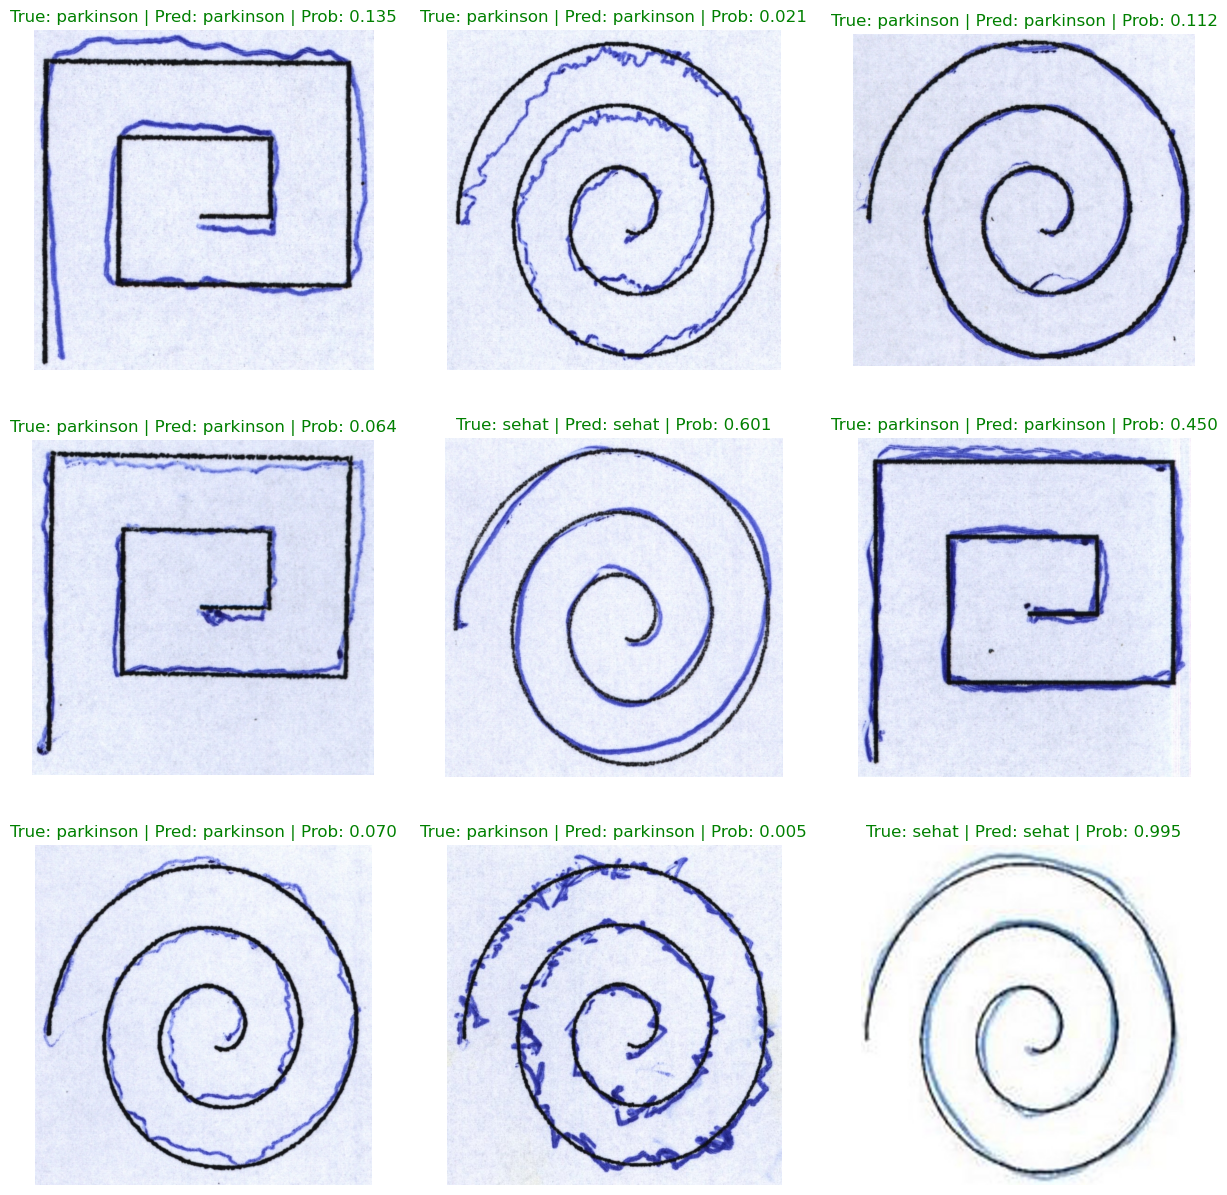

In [88]:
import random
num_images_to_plot = 9
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images in a 3x3 grid
plt.figure(figsize=(15, 15))
for i, image_path in enumerate(test_image_path_sample):
    plt.subplot(3, 3, i + 1) 
    if image_path.parent.name == 'sehat':
        true_class = 'sehat'
    else:
        true_class = 'parkinson'
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=['parkinson', 'sehat'],
                        true_class=true_class,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))
plt.show()

In [89]:
vitb16_0 = VisionTransformerClassifier.load_from_checkpoint(
    '../models/checkpoints/vitb16-epoch=19-val_loss=0.29-val_acc=0.89.ckpt'
)

# Set to eval mode
vitb16_0.eval()

VisionTransformerClassifier(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
       

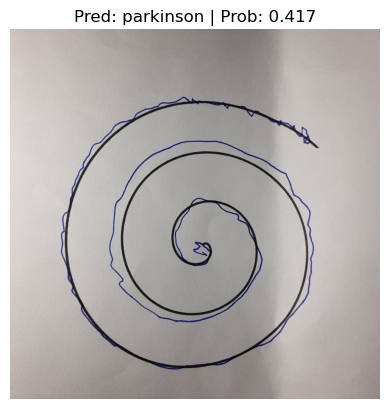

In [91]:
image_path = "../data/custom-patient.jpg"
class_names = ["parkinson", "sehat"]
pred_and_plot_image(model=model, image_path=image_path, class_names=class_names, device=device)

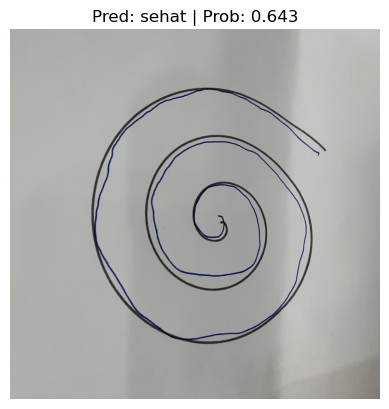

In [92]:
image_path = "../data/custom-healthy.jpg"
class_names = ["parkinson", "sehat"]
pred_and_plot_image(model=model, image_path=image_path, class_names=class_names, device=device)